In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files
####新项目，近5年分红去高去低*回购率排名，同时要求分红逆序数（假）不能超过6

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    raw_data = []
    count = 0
    
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        raw_data.append(dat_cell)
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            #pb
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = dat_cell['bond_nm'] # 转债名称
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
            lst_dat['redeem_price_ratio']  =  dat_cell['redeem_price_ratio']
            lst_dat['redeem_count_days'] =  dat_cell['redeem_count_days']
            lst_dat['redeem_real_days']  =  dat_cell['redeem_real_days']
            
            
            
  
            lst_data.append(lst_dat)
           
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data,raw_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio2'] #####ratio is float ratio, ratio is total ratio
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio2']#####ratio is float ratio, ratio is total ratio
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
   
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        
    
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
 
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data,raw_data = get_dat()
pd.DataFrame.from_dict(raw_data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 383 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 404 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

In [37]:
put_df = put_arbitrage(data)

Finished processing 38 items


Strong Sell 113039 嘉泽转债 175.72 178.605
Sell 113585 寿仙转债 140.77 143.163
Strong Sell 113595 花王转债 90.93 211.509
Strong Sell 127034 绿茵转债 104.451 152.991
Strong Sell 128062 亚药转债 90.97 344.708
Sell 128096 奥瑞转债 146.944 151.220
Strong Sell 128127 文科转债 98.6 162.605

Add  128100 搜特转债 103.999 124.434
Add  113009 广汽转债 121.91 128.167
Add  113607 伟20转债 124.89 129.305
Add  132018 G三峡EB1 126.96 130.916
Add  113610 灵康转债 116.82 133.413
Add  113026 核能转债 121.0 134.194
Add  128133 奇正转债 116.683 134.639

Buy  113009 广汽转债 121.91 128.167
Buy  113030 东风转债 121.69 135.241
Buy  113541 荣晟转债 126.14 135.496
Buy  110070 凌钢转债 123.57 136.004
Buy  128040 华通转债 115.879 136.857
Buy  132014 18中化EB 134.05 137.394
Buy  113600 新星转债 124.47 138.009
Buy  123073 同和转债 121.666 138.299
Buy  128106 华统转债 124.176 138.707
Buy  128037 岩土转债 109.0 138.765
today coef [ 3.38284324e-03 -4.14558661e-02  9.62169417e+01]
mse=56.485


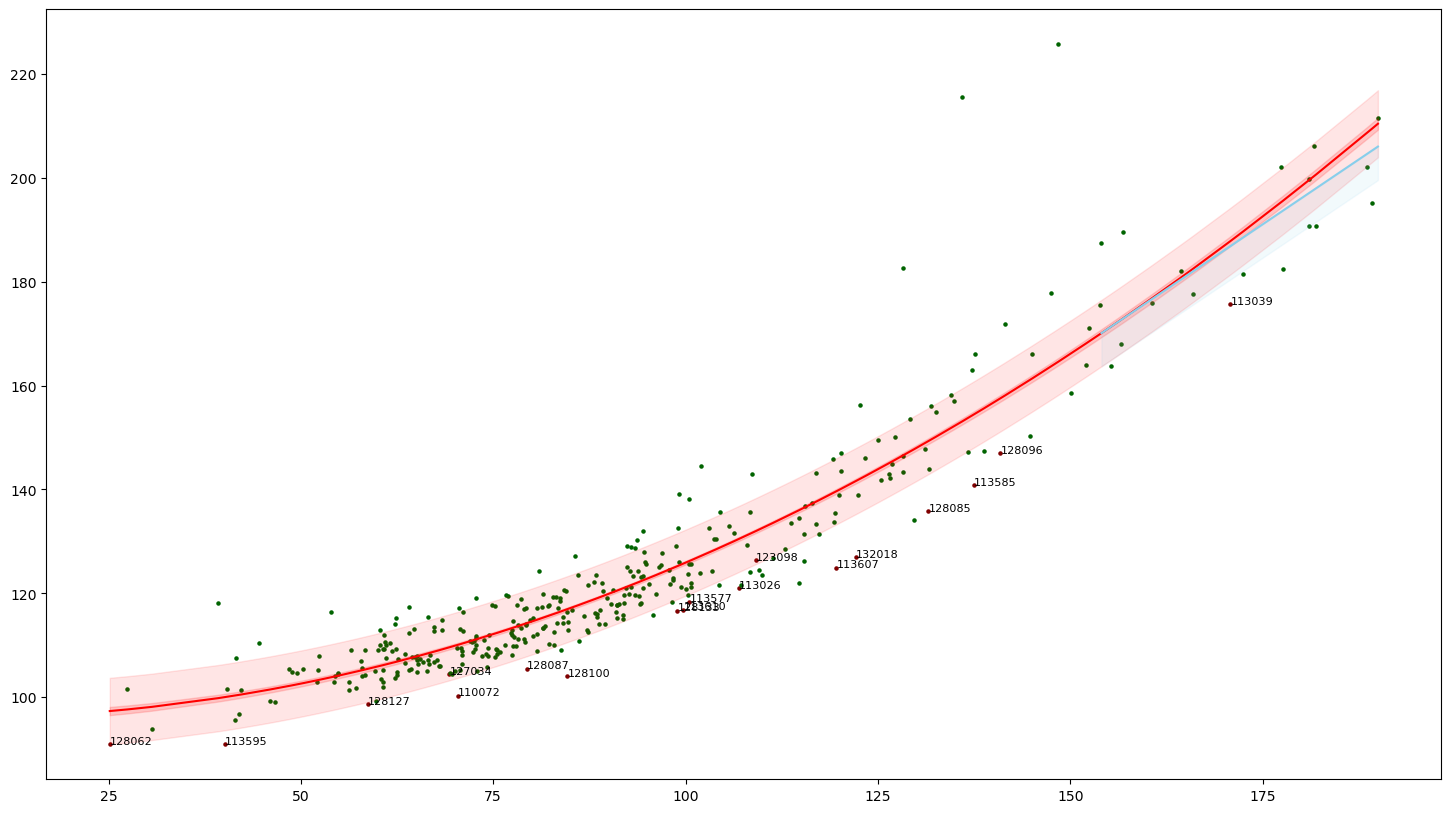

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113525,台华转债,189.212924,195.130,3.127205,198.257205,-1.857855,205.273157,198.823858,211.722455
128128,齐翔转2,181.970513,190.820,4.863144,195.683144,-0.404001,198.030746,191.594041,204.467450
128050,钧达转债,181.015510,190.678,5.337935,196.015935,0.019603,197.075742,190.640628,203.510856
113034,滨化转债,188.532112,202.140,7.217809,209.357809,2.016576,204.592345,198.144270,211.040420
128017,金禾转债,181.036871,199.789,10.358182,210.147182,4.787030,197.097104,190.661954,203.532253
113528,长城转债,189.987161,211.590,11.370684,222.960684,6.008770,206.047394,199.596694,212.498094
123102,华自转债,181.645021,206.172,13.502698,219.674698,7.791592,197.705254,191.269093,204.141414


In [40]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

Sell 123098 一品转债 126.39 142.214 15.824 0.619
Sell 127034 绿茵转债 104.451 152.991 50.772 1.196
Sell 128062 亚药转债 90.97 344.708 261.524 0.060

Add  113607 伟20转债 124.89 129.305 4.415 -6.300
Add  132018 G三峡EB1 126.96 130.916 3.956 -6.124
Add  113009 广汽转债 121.91 128.167 6.257 -5.951
Add  128100 搜特转债 103.999 124.434 22.911 -5.941
Add  132014 18中化EB 134.05 137.394 3.344 -5.187
Add  128085 鸿达转债 135.78 138.994 3.214 -5.004
Add  113585 寿仙转债 140.77 143.163 2.393 -4.934

Strong Buy 113607 伟20转债 124.89 129.305 4.415 -6.300
Strong Buy 132018 G三峡EB1 126.96 130.916 3.956 -6.124
Strong Buy 113009 广汽转债 121.91 128.167 6.257 -5.951
Strong Buy 128100 搜特转债 103.999 124.434 22.911 -5.941
Strong Buy 132014 18中化EB 134.05 137.394 3.344 -5.187
Strong Buy 113541 荣晟转债 126.14 135.496 9.356 -3.028
Buy 123083 朗新转债 150.3 154.108 3.808 -2.871
Buy 123103 震安转债 182.493 185.236 2.743 -2.542
Strong Buy 113026 核能转债 121.0 134.194 13.194 -2.481
Strong Buy 128087 孚日转债 105.509 137.070 32.937 -2.193
Strong Buy 113610 灵康转债 116.82 133.4

In [41]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113607,伟20转债,119.609724,124.890,4.414587,129.304587,-6.300201,139.655017,133.287372,146.022662
132018,G三峡EB1,122.129029,126.960,3.955629,130.915629,-6.123645,141.610774,135.241723,147.979825
113009,广汽转债,114.730946,121.910,6.257295,128.167295,-5.951364,135.989679,129.624422,142.354937
128100,搜特转债,84.613200,103.999,22.911083,124.434386,-5.941168,116.928334,110.568033,123.288635
132014,18中化EB,129.712715,134.050,3.343762,137.393762,-5.186788,147.757240,141.383250,154.131230
128085,鸿达转债,131.552476,135.780,3.213565,138.993565,-5.003538,149.306987,142.931638,155.682336
113585,寿仙转债,137.479980,140.770,2.393090,143.163090,-4.933758,154.455847,148.075697,160.835998
110072,广汇转债,70.397827,100.290,42.461784,140.179992,-3.287958,110.063416,103.699600,116.427233
113541,荣晟转债,115.348108,126.140,9.355933,135.495933,-3.028092,136.444445,130.078909,142.809980


In [42]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,103.999,124.434386
113607,伟20转债,124.890,129.304587
132018,G三峡EB1,126.960,130.915629
113610,灵康转债,116.820,133.412632
113026,核能转债,121.000,134.194243
128133,奇正转债,116.683,134.638828
113577,春秋转债,118.400,136.246437
128087,孚日转债,105.509,137.070161
128085,鸿达转债,135.780,138.993565


today quartile 151.1385310659587


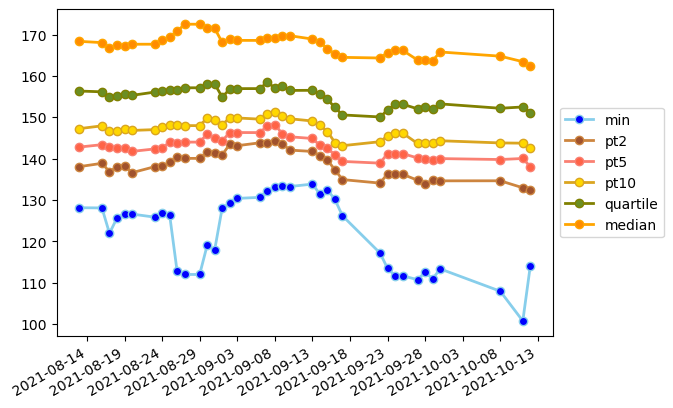

In [43]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 22.353098198237


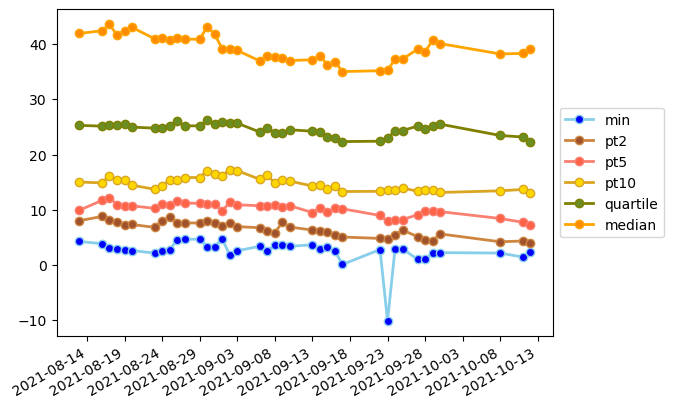

In [44]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 109.385


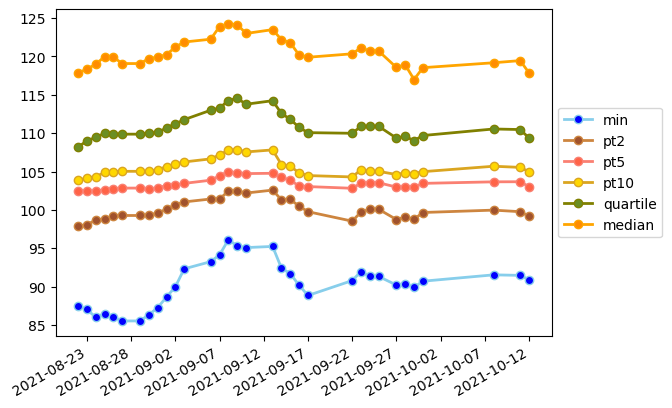

In [45]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [46]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_dt,force_redeem_price,redeem_price_ratio,redeem_count_days,redeem_real_days,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
110033,国贸转债,600755.ss,厦门国贸,112.050,112.35,-0.27%,AAA,0.57,2.2%,2.1%,...,2021-11-04,8.74,130.000,15,15,0.000000,0.0,109.760369,0.020860,114.136027
128018,时达转债,002527.sz,新时达,104.999,102.17,2.76%,AA,1.71,9.2%,7.2%,...,2021-10-27,9.57,130.000,15,16,0.011565,0.0,95.169130,0.103288,114.171307
123051,今天转债,300532.sz,今天国际,113.109,113.68,-0.50%,A+,3.25,6.3%,3.9%,...,2021-10-14,11.31,130.000,15,12,0.014816,0.0,108.853939,0.039090,115.536378
120004,20华菱EB,000932.sz,华菱钢铁,122.900,124.80,-1.52%,AAA,1.06,2.8%,2.3%,...,2021-10-21,6.40,130.000,15,26,0.000000,0.0,121.317697,0.013043,124.204264
128100,搜特转债,002503.sz,搜于特,103.999,98.15,5.96%,A,2.02,19.8%,16.3%,...,None,2.11,130.000,15,0,0.024757,0.0,84.613200,0.229111,124.434386
113009,广汽转债,601238.ss,广汽集团,121.910,116.74,4.43%,AAA,1.92,2.2%,1.5%,...,None,18.10,130.000,15,12,0.000000,0.0,114.730946,0.062573,128.167295
113607,伟20转债,603568.ss,伟明环保,124.890,124.37,0.42%,AA,5.88,3.2%,3.2%,...,None,28.22,130.000,20,16,0.000000,0.0,119.609724,0.044146,129.304587
132018,G三峡EB1,600900.ss,长江电力,126.960,127.42,-0.16%,AAA,2.94,3.4%,3.4%,...,None,20.09,120.000,15,16,0.000000,0.0,122.129029,0.039556,130.915629
113610,灵康转债,603669.ss,灵康药业,116.820,107.08,9.09%,AA-,4.73,6.9%,6.9%,...,None,11.19,130.000,15,0,0.005640,0.0,99.712707,0.171566,133.412632


In [47]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_dt,force_redeem_price,redeem_price_ratio,redeem_count_days,redeem_real_days,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
128133,奇正转债,002287.sz,奇正藏药,116.683,103.96,12.24%,AA,4.79,4.9%,4.9%,...,None,38.71,130.000,15,0,0.000000,0.0,98.920928,0.179558,134.638828
113030,东风转债,601515.ss,东风股份,121.690,110.85,9.78%,AA,2.13,3.1%,3.1%,...,None,8.38,130.000,15,0,0.000000,0.0,107.167355,0.135514,135.241371
113541,荣晟转债,603165.ss,荣晟环保,126.140,121.96,3.43%,AA-,2.02,4.7%,4.7%,...,None,14.09,130.000,15,1,0.000000,0.0,115.348108,0.093559,135.495933
110070,凌钢转债,600231.ss,凌钢股份,123.570,113.01,9.34%,AA,0.94,2.5%,2.5%,...,None,3.50,130.000,15,14,0.000000,0.0,109.904911,0.124336,136.003556
113577,春秋转债,603890.ss,春秋电子,118.400,104.24,13.58%,AA-,2.57,4.1%,3.6%,...,None,14.11,130.000,15,0,0.000000,0.0,100.469733,0.178464,136.246437
128040,华通转债,002758.sz,浙农股份,115.879,100.10,15.76%,AA,1.60,11.2%,4.5%,...,None,13.20,130.000,15,0,0.000000,0.0,95.785349,0.209778,136.856792
128087,孚日转债,002083.sz,孚日股份,105.509,92.00,14.68%,AA-,1.02,17.3%,17.3%,...,None,5.85,130.000,15,0,0.013756,0.0,79.367818,0.329368,137.070161
132014,18中化EB,601117.ss,中国化学,134.050,134.24,0.18%,AAA,1.57,3.2%,2.6%,...,None,9.61,130.000,15,30,0.000000,0.0,129.712715,0.033438,137.393762
113600,新星转债,603978.ss,深圳新星,124.470,125.53,-0.85%,AA-,2.87,11.6%,11.6%,...,None,31.00,130.000,15,2,0.000548,0.0,109.574353,0.135941,138.009331


In [48]:
lp_df[0:20]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113607,伟20转债,119.609724,124.890,4.414587,129.304587,-6.300201,139.655017,133.287372,146.022662
132018,G三峡EB1,122.129029,126.960,3.955629,130.915629,-6.123645,141.610774,135.241723,147.979825
113009,广汽转债,114.730946,121.910,6.257295,128.167295,-5.951364,135.989679,129.624422,142.354937
128100,搜特转债,84.613200,103.999,22.911083,124.434386,-5.941168,116.928334,110.568033,123.288635
132014,18中化EB,129.712715,134.050,3.343762,137.393762,-5.186788,147.757240,141.383250,154.131230
128085,鸿达转债,131.552476,135.780,3.213565,138.993565,-5.003538,149.306987,142.931638,155.682336
113585,寿仙转债,137.479980,140.770,2.393090,143.163090,-4.933758,154.455847,148.075697,160.835998
110072,广汇转债,70.397827,100.290,42.461784,140.179992,-3.287958,110.063416,103.699600,116.427233
113541,荣晟转债,115.348108,126.140,9.355933,135.495933,-3.028092,136.444445,130.078909,142.809980


In [49]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

162.41132727042626
117.873
39.130043024997306


In [50]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128062,亚药转债,25.162942,90.97,261.523701,344.708018,0.059568,97.315717,90.915843,103.715592
132011,17浙报EB,27.462128,101.50,269.599905,369.351917,11.254122,97.629709,91.232575,104.026844


In [51]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,last_time,force_redeem,redeem_dt,force_redeem_price,redeem_price_ratio,redeem_count_days,redeem_real_days,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,90.97,27.94,225.61%,BB,3.95,42.4%,39.5%,...,3.474,X,None,21.12,130.000,15,0,102.00,0.075215,1.578082
113595,花王转债,603007.ss,ST花王,90.93,45.81,98.50%,BBB+,0.95,31.2%,31.0%,...,4.773,X,None,9.00,130.000,15,0,102.64,0.042925,2.882192
113596,城地转债,603887.ss,城地香江,93.95,34.01,176.27%,AA-,0.90,41.1%,32.3%,...,4.792,X,None,31.54,130.000,15,0,102.48,0.030406,2.901370
113576,起步转债,603557.ss,ST起步,95.66,43.60,119.39%,A,1.41,11.7%,11.7%,...,4.493,N,None,13.71,130.000,15,0,103.04,0.029027,2.597260
128044,岭南转债,002717.sz,岭南股份,99.08,49.91,98.52%,AA-,1.05,21.0%,14.0%,...,2.841,X,None,7.27,130.000,15,0,101.20,0.022718,0.942466
113589,天创转债,603608.ss,天创时尚,96.79,46.79,106.88%,AA,1.46,24.3%,24.3%,...,4.699,X,None,15.98,130.000,20,0,102.48,0.020570,2.805479
128127,文科转债,002775.sz,文科园林,98.60,80.94,21.81%,AA-,0.89,53.9%,46.9%,...,4.855,X,None,6.34,130.000,15,0,102.64,0.013664,2.958904
113578,全筑转债,603030.ss,全筑股份,99.16,67.24,47.48%,AA,0.97,20.2%,18.7%,...,4.521,X,None,6.83,130.000,15,0,102.48,0.012627,2.624658
127019,国城转债,000688.sz,国城矿业,99.24,47.58,108.58%,AA,4.49,7.5%,7.5%,...,4.756,X,None,27.38,130.000,15,0,102.40,0.011009,2.863014


In [52]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y + d 
    #return a* x + b*1/x + c*y +d

In [53]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    redeem_default_prob = 0.5    #####probility of force redeem if conditons is satisfied
    time_decay_factor = 0.25  ######hyper parameter simulated time decay 
    redeem_default_days = 20 ####20 days to be forced redeem
    
    regression_data = []
    for cb_id,row in db_df.iterrows():
        name = row['name']
        price = row['price']
        value = row['new_convert_value']
        premium = row['new_premium']
        db_low = row['db_low']
        force_redeem = row['force_redeem']
        convert_value       = float(row['convert_value'])
        redeem_price_ratio  = float(row['redeem_price_ratio'])
        redeem_count_days   = int(row['redeem_count_days'])
        redeem_real_days    = int(row['redeem_real_days'])
        
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        time_to_redeem = 0
        redeem_prob = 1
        if(force_redeem == 'Y'):
            redeem_dt    = row['redeem_dt']
            expire_dt = redeem_dt     
            if(redeem_dt == None):
                time_to_redeem = redeem_default_days/365 
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_redeem = days_interval.days/365
            time_to_exp = time_to_redeem
        else:
            maturity_dt  = row['maturity_dt']
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
            redeem_prob = 0
            if(force_redeem == 'X' and convert_value >= redeem_price_ratio):
                days_to_satisfied = redeem_count_days-redeem_real_days if redeem_count_days>redeem_real_days  else 0
                days_to_satisfied += redeem_default_days
                time_to_redeem = days_to_satisfied/365
                redeem_prob = redeem_default_prob*redeem_real_days/redeem_count_days if redeem_count_days>redeem_real_days else redeem_default_prob
                #print("可能强赎:%s,%s,%s,%s,%d,redeem_prob:%.3f"%(cb_id,name,convert_value,price,redeem_real_days,redeem_prob))
                
        time_value = (1-redeem_prob) * time_to_exp ** time_decay_factor + redeem_prob * time_to_redeem ** time_decay_factor
            
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            #print("妖债:%s,%s,%s,%s"%(cb_id,name,convert_value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        regression_data.append({'id':cb_id,'name':name,'db_low':db_low,'value':value,'price':price,'time':time_to_exp,
                                'expire':expire_dt,'time_value':time_value,'redeem_prob':redeem_prob})

    
    regression_df = pd.DataFrame(regression_data)
    regression_df = regression_df.set_index(['id'])
    #y_df.sort_values('deviation',ascending=True)
    
    x  = regression_df['value']
    y  = regression_df['time_value']
    z = regression_df['price']
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)

    td_data = []
    se = 0
    for cb_id,row in regression_df.iterrows():
        cb_name = row['name']
        db_low  = row['db_low']
        value      = row['value']
        time_to_exp = row['time']
        expire_dt  = row['expire']
        time_value = row['time_value']
        price = row['price']
        premium = price/value-1
        fit_price = func((value,time_value), *popt)
        
                     
        origin_time_value = time_to_exp ** time_decay_factor
        origin_fit_price = func((value,origin_time_value), *popt)
        
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_value + popt[3]
            origin_fit_price = value+intercept + popt[2] * origin_time_value + popt[3]
         
           ####set minimum fit price
        minimum_fit_price = origin_fit_price/(1+premium)
        if(fit_price < minimum_fit_price):
            fit_price = minimum_fit_price
        
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'ori_fit_price':origin_fit_price,'min_fit_price':minimum_fit_price,'expire_dt':expire_dt,'redeem_prob':row['redeem_prob']}
        td_data.append(item)
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    return popt,td_df

In [54]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,position1,position2 = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            value = td_df.loc[cb_id]['value']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            expire_dt = td_df.loc[cb_id]['expire_dt']
            redeem_prob = td_df.loc[cb_id]['redeem_prob']
            item = {'id':cb_id,'name':cb_name,'time_to_exp':time_to_exp,'value':value,'price':price,'premium':premium,
                'deviation':deviation,'expire_dt':expire_dt,'redeem_prob':redeem_prob,'position1':position1,'positon2':position2}
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('deviation',ascending=True)
    return my_df
    

In [55]:
# 搞一个回测，锚定转债中位数价格，来选取加仓，买入，持有，减仓和清仓区间。中位数价格高，自然区间小，中位数价格低，自然区间大。（但是都把钱放里面？）
# 爬取底层证券的现金及现金等价物，取过去两年，线性回归，计算超过转债赎回价格的概率。
popt,td_df = three_factor_arbitrage(db_df)

[ 3.56394821e-03 -8.12101330e-02  1.12452294e+01  8.21795124e+01]
151.68712769443619
mse=54.930
adjuse mse=54.433


In [56]:
 buy_sell_three(td_df,'mycb_list.csv',show_price=True)

Sell 123098 一品转债 5.295890410958904 126.390 0.158 -4.838,redeem_prob:0.00

Add  128100 搜特转债 4.413698630136986 103.999 0.229 -11.205,redeem_prob:0.00
Add  113607 伟20转债 5.057534246575343 124.890 0.044 -10.995,redeem_prob:0.00
Add  113595 花王转债 4.772602739726027 90.930 1.267 -10.217,redeem_prob:0.00
Add  110072 广汇转债 4.8493150684931505 100.290 0.425 -9.496,redeem_prob:0.00
Add  113585 寿仙转债 4.657534246575342 140.770 0.024 -9.120,redeem_prob:0.00
Add  110033 国贸转债 0.06301369863013699 112.050 0.021 -8.032,redeem_prob:1.00
Add  128087 孚日转债 4.183561643835616 105.509 0.329 -7.664,redeem_prob:0.00

Have 128100 搜特转债 4.413698630136986 103.999 0.229 -11.205,redeem_prob:0.00
Have 113607 伟20转债 5.057534246575343 124.890 0.044 -10.995,redeem_prob:0.00
Have 113595 花王转债 4.772602739726027 90.930 1.267 -10.217,redeem_prob:0.00
Have 110072 广汇转债 4.8493150684931505 100.290 0.425 -9.496,redeem_prob:0.00
Have 113585 寿仙转债 4.657534246575342 140.770 0.024 -9.120,redeem_prob:0.00
Buy 110033 国贸转债 0.06301369863013699 112

,name,time_to_exp,value,price,premium,deviation,expire_dt,redeem_prob,position1,positon2
id,,,,,,,,,,
128100,搜特转债,4.413699,84.613200,103.999,0.229111,-11.205369,2026-03-11,0.0,20,20
113607,伟20转债,5.057534,119.609724,124.890,0.044146,-10.994564,2026-11-01,0.0,20,0
113595,花王转债,4.772603,40.113449,90.930,1.266821,-10.217069,2026-07-20,0.0,20,0
110072,广汇转债,4.849315,70.397827,100.290,0.424618,-9.495601,2026-08-17,0.0,30,0
113585,寿仙转债,4.657534,137.479980,140.770,0.023931,-9.119619,2026-06-08,0.0,20,0
128087,孚日转债,4.183562,79.367818,105.509,0.329368,-7.664337,2025-12-17,0.0,20,20
113610,灵康转债,5.136986,99.712707,116.820,0.171566,-7.613011,2026-11-30,0.0,10,0
128127,文科转债,4.854795,58.668814,98.600,0.680620,-7.308463,2026-08-19,0.0,10,0
128133,奇正转债,4.945205,98.920928,116.683,0.179558,-7.239764,2026-09-21,0.0,10,10


In [57]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,
128100,搜特转债,84.613200,4.413699,103.999,0.229111,124.434386,-11.205369,117.123072,117.123072,95.290896,2026-03-11,0.0
113607,伟20转债,119.609724,5.057534,124.890,0.044146,129.304587,-10.994564,140.317273,140.317273,134.384741,2026-11-01,0.0
113595,花王转债,40.113449,4.772603,90.930,1.266821,211.509272,-10.217069,101.277603,101.277603,44.678257,2026-07-20,0.0
110072,广汇转债,70.397827,4.849315,100.290,0.424618,140.179992,-9.495601,110.812293,110.812293,77.783873,2026-08-17,0.0
113585,寿仙转债,137.479980,4.657534,140.770,0.023931,143.163090,-9.119619,154.895918,154.895918,151.275753,2026-06-08,0.0
110033,国贸转债,109.760369,0.063014,112.050,0.020860,114.136027,-8.032170,121.836081,121.836081,119.346481,2021-11-04,1.0
128087,孚日转债,79.367818,4.183562,105.509,0.329368,137.070161,-7.664337,114.266792,114.266792,85.955757,2025-12-17,0.0
113610,灵康转债,99.712707,5.136986,116.820,0.171566,133.412632,-7.613011,126.446377,126.446377,107.929383,2026-11-30,0.0
128127,文科转债,58.668814,4.854795,98.600,0.680620,162.604752,-7.308463,106.374328,106.374328,63.294682,2026-08-19,0.0


In [58]:
func((127.881119,(25/365)**0.5), *popt)*0.375 + func((127.881119,5.106849**0.5), *popt)*(1-0.375)

147.06393187565504

In [59]:
128.74/138-1

-0.06710144927536221

In [60]:
td_df.loc['113051']

name                   节能转债
value            155.292313
time_to_exp        5.693151
price                163.78
premium            0.054656
db_low            169.24562
deviation         -5.241438
fit_price        172.839262
ori_fit_price    172.839262
min_fit_price     163.88209
expire_dt        2027-06-21
redeem_prob             0.0
Name: 113051, dtype: object

In [61]:
db_df.loc['113051']

name                        节能转债
stock_id               601016.ss
stock_name                  节能风电
price                     163.78
convert_value             178.27
premium_rt                -8.13%
rating_cd                    AA+
pb                          3.45
convert_amt_ratio           9.3%
convert_amt_ratio2          8.3%
next_put_dt           2025-06-20
put_price                100.000
put_convert_price           2.83
maturity_dt           2027-06-21
redeem_price             110.000
last_time                  5.693
force_redeem                   X
redeem_dt                   None
force_redeem_price          5.26
redeem_price_ratio       130.000
redeem_count_days             15
redeem_real_days               0
redeem_CAGR                  0.0
put_CAGR                     0.0
new_convert_value     155.292313
new_premium             0.054656
db_low                 169.24562
Name: 113051, dtype: object

In [62]:
td_df[(td_df['time_to_exp']<0)]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,


In [63]:
value = 160.102203
year = 5.208219
limit_value = 144.03443402217655
intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
time_value = year**0.5
#func((value,time_value),*popt)
value+intercept + popt[2] * time_value + popt[3]

186.1509296458275

In [64]:
170.37/181.98-1

-0.06379821958456966

In [65]:
121.98/(1+0.07*1.2198)

112.38398136699756

In [66]:
1+0.07*1.2198

1.085386

In [67]:
0.091*1.2954

0.11788140000000001

In [68]:
135.3/141.64-1

-0.044761366845523676

In [69]:
130/140-1

-0.0714285714285714